In [1]:
from __future__ import division, unicode_literals

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)

import numpy as np
import scipy.stats as st
from time import time

import pystan
from pystan import StanModel

/Users/matsuken/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
pystan.__version__

'2.8.0.0'

In [3]:
schools_dat = {'J': 8,                                     # number of schools
               'y': [28,  8, -3,  7, -1,  1, 18, 12],      # estimated treatment effects
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}  # s.e. of effect estimates

In [4]:
headers = "A,B,C,D,E,F,G,H".split(",")
headers
#print tabulate(titanic[0:5], headers, tablefmt="pipe")

[u'A', u'B', u'C', u'D', u'E', u'F', u'G', u'H']

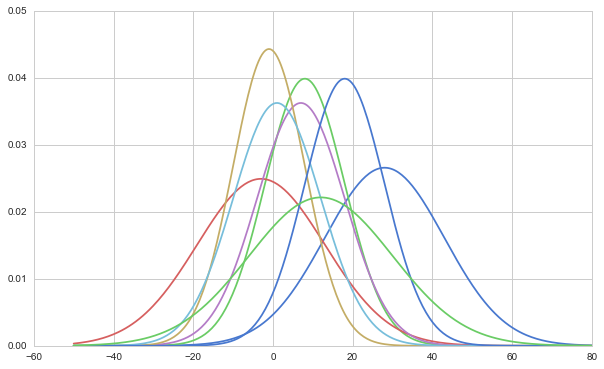

In [5]:
# グラフ描画
plt.figure(figsize=(10,6))
xx = np.linspace(-50, 80, 301)
plt.ylim(0, 0.05)
for m, s in zip(schools_dat['y'], schools_dat['sigma']):
    plt.plot(xx, st.norm.pdf(xx, m,s))


In [6]:
code = """data {
    int<lower=0> J;          // number of schools
    real y[J];               // 
    real<lower=0> sigma[J];  // s.e. of effect estimates
} parameters {
    real mu; 
    real<lower=0> tau;
    real eta[J];
} transformed parameters {
    real theta[J];
    for (j in 1:J)
        theta[j] <- mu + tau * eta[j];
}
    model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);}
"""

In [7]:
%time stm = StanModel(model_code=code)

CPU times: user 1.5 s, sys: 124 ms, total: 1.62 s
Wall time: 21.6 s


In [8]:
n_itr = 3000
n_warmup = 200
chains = 2

%time fit = stm.sampling(data=schools_dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)
la    = fit.extract(permuted=True)  # return a dictionary of arrays
names = fit.model_pars 

n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

CPU times: user 18.4 ms, sys: 30.3 ms, total: 48.6 ms
Wall time: 1.32 s


/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/matsuken/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)


In [9]:
print fit

Inference for Stan model: anon_model_e2054dad35ba70aa7957970c3954d10a.
2 chains, each with iter=3000; warmup=200; thin=1; 
post-warmup draws per chain=2800, total post-warmup draws=5600.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         7.95    0.07   5.26  -2.76   4.63   7.94  11.32  18.38 5600.0    1.0
tau        6.56    0.07   5.52   0.18   2.46   5.23   9.04  20.65 5600.0    1.0
eta[0]     0.39    0.01   0.96  -1.54  -0.23   0.42   1.04   2.18 5600.0    1.0
eta[1]  -5.1e-3    0.01   0.89  -1.84  -0.58  -0.01   0.57   1.77 5600.0    1.0
eta[2]    -0.21    0.01   0.92   -2.0  -0.83  -0.22   0.39   1.62 5600.0    1.0
eta[3]    -0.04    0.01   0.88  -1.74  -0.64  -0.05   0.53   1.72 5600.0    1.0
eta[4]    -0.33    0.01    0.9  -2.08  -0.94  -0.35   0.26   1.52 5600.0    1.0
eta[5]    -0.18    0.01    0.9  -1.93   -0.8  -0.19    0.4   1.61 5600.0    1.0
eta[6]     0.35    0.01   0.91  -1.47  -0.25   0.35   0.94   2.11 5600.0    1.0
eta[7]     0

In [10]:
# 各パラメーターのEAP推定量リスト抽出
mean_list = np.array(fit.summary()['summary'])[:,0]
mean_list

array([  7.94565412e+00,   6.55509999e+00,   3.94574749e-01,
        -5.10483276e-03,  -2.12850806e-01,  -4.49955157e-02,
        -3.28768301e-01,  -1.84253181e-01,   3.45437948e-01,
         6.45413381e-02,   1.13877096e+01,   7.94463199e+00,
         6.10815486e+00,   7.53633511e+00,   5.20923860e+00,
         6.27744954e+00,   1.07704181e+01,   8.44478385e+00,
        -5.00329452e+00])

In [15]:
mu = mean_list[0]
tau = mean_list[1]
eta = mean_list[2:10]
theta = mean_list[10:18]

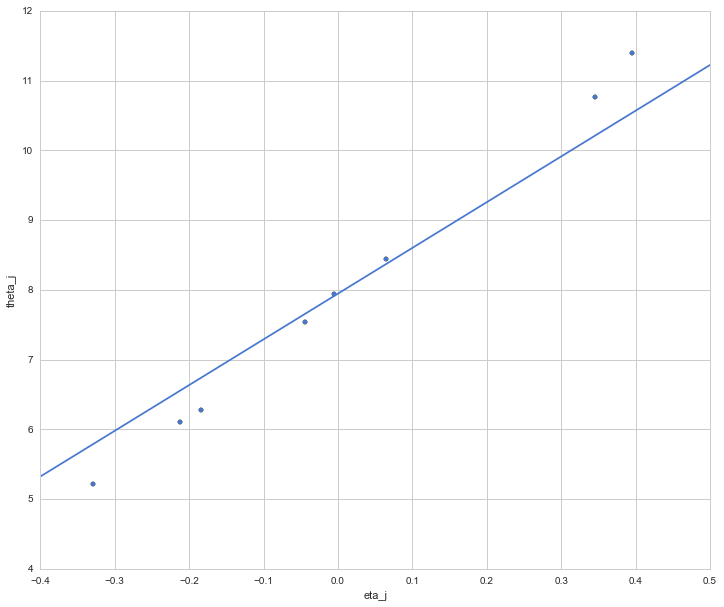

In [30]:
plt.figure(figsize=(12,10))
plt.xlim(-.4, .5)
plt.scatter(eta, theta, s=20)
xxx = np.linspace(-.4,.5,201)
plt.plot(xxx, mu + xxx*tau)
plt.xlabel("eta_j")
plt.ylabel("theta_j")

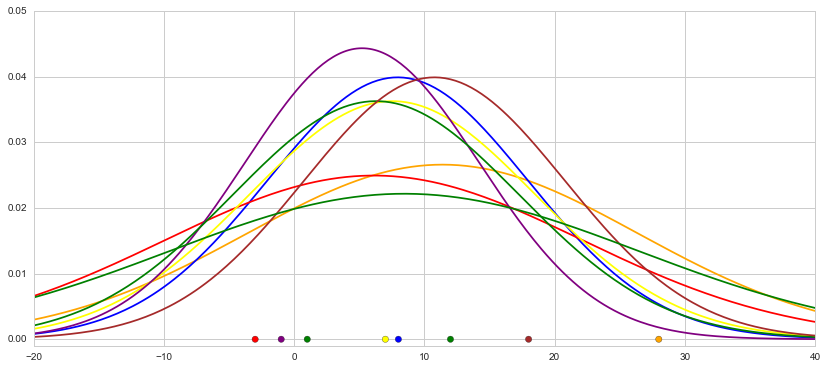

In [42]:
plt.figure(figsize=(14,6))
xx = np.linspace(-20, 40, 301)
plt.ylim(-0.001, 0.05)
plt.xlim(-20, 40)
#for y in schools_dat['y']:
#    plt.scatter([y],[0], s=40)

color = "orange,blue,red,yellow,purple,green,brown,green".split(",")
plt.scatter(schools_dat['y'],np.zeros(len(schools_dat['y'])), s=40, c=color)

for t, s, c in zip(theta, schools_dat['sigma'], color):
    plt.plot(xx, st.norm.pdf(xx, t,s), c=c)

In [17]:



for e, t in zip(eta, mean_list[10:18]):
    #plt.plot(xx, st.norm.pdf(xx, m,s))
    print t, mu + tau*e

11.3877096353 10.5321310504
7.94463199009 7.91219143087
6.10815486388 6.55039580471
7.53633511354 7.65070401566
5.2092385997 5.79054503536
6.27744954248 6.73785609861
10.7704181068 10.2100344107
8.44478385353 8.3687290444


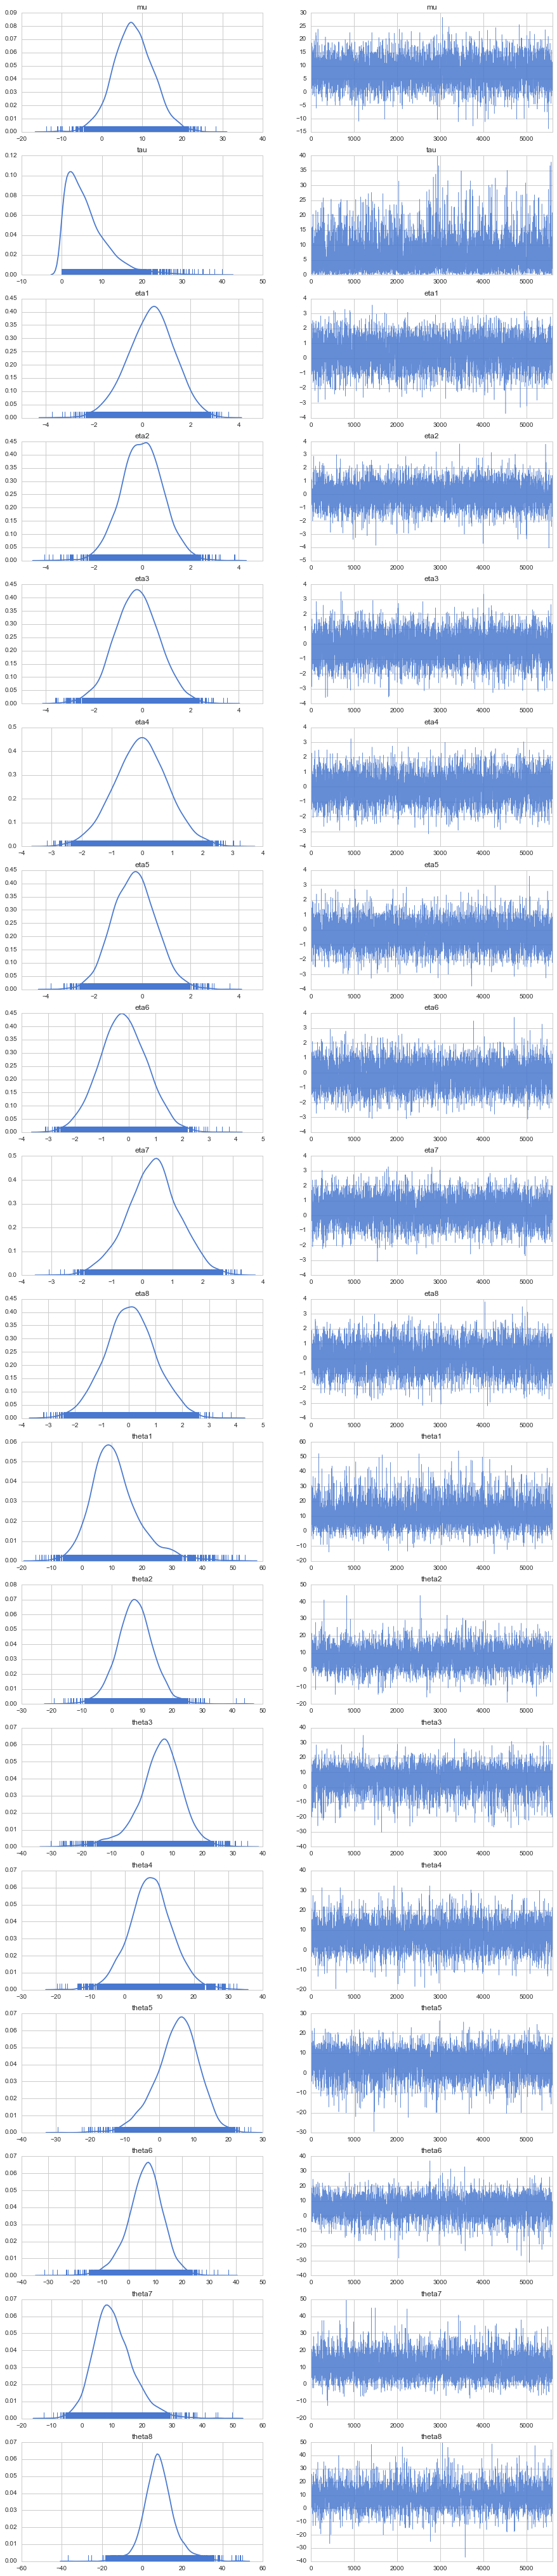

In [25]:
f, axes = plt.subplots(n_param, 2, figsize=(15, 4*n_param))
cnt = 0
for name in names:
    dat = la[name]
    if dat.ndim == 2:
        for j in range(dat.shape[1]):
            d = dat[:,j]
            sns.distplot(d, hist=False, rug=True, ax=axes[cnt, 0])
            sns.tsplot(d,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1
    else:
        # Intercept
        sns.distplot(dat, hist=False, rug=True, ax=axes[cnt, 0])
        sns.tsplot(dat,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
        cnt += 1

name_list = []
for name in names:
    if la[name].ndim == 2:
        for i in range(dat.shape[1]):
            name_list.append("{}{}".format(name,i+1))
    else:
        name_list.append(name)

for i in range(2):
    for j, t in enumerate(name_list):
        axes[j, i].set_title(t)
plt.show()


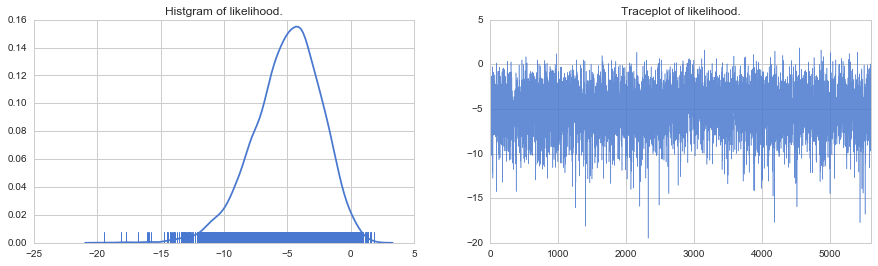

In [24]:
# Likelihood
f, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.distplot(la['lp__'], hist=False, rug=True, ax=axes[0])
sns.tsplot(la['lp__'],   alpha=0.8, lw=.5, ax=axes[1])
axes[0].set_title("Histgram of likelihood.")
axes[1].set_title("Traceplot of likelihood.")
plt.show()